<center><h1> Hypertuner </h1>
John Ignacio R.M. Martes 13 SPOOKY month 2020 MUAJAJAJAJA </center>

In [1]:
#ada library
ada_parent_dir = "../"
import sys
sys.path.append(ada_parent_dir)
from ada2.data import read_dataset, split_dataset, all_hyperparams_comb
from ada2.model import BinaryClassifier
from ada2.plot import plot_confidence_matrix
import pandas as pd
from IPython.core.display import display, HTML

#keras
from tensorflow.keras.optimizers import Adam, Adadelta, Adagrad, Adamax
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import Model, Sequential

Using TensorFlow backend.
Welcome to JupyROOT 6.20/04


In [2]:
from kerastuner import HyperModel, Hyperband, RandomSearch
from tensorflow.keras.callbacks import Callback
from IPython.display import clear_output

In [3]:
source_path = "../processed_data/xtohhOct2020"
bg = "Xtohh_background"
seed = 420
signal = "Xtohh2000"

In [4]:
# Read xtohh dataset in SR tag 2
df = read_dataset(source_path, signal, bg, "SR", 2)
df

,EventWeight,label,m_FJpt,m_FJeta,m_FJphi,m_FJm,m_DTpt,m_DTeta,m_DTphi,m_DTm,m_dPhiFTwDT,m_dRFJwDT,m_dPhiDTwMET,m_MET,m_hhm,m_bbttpt
0,0.001020,1,885.55927,0.104927,-2.448576,127604.30,623.22710,-0.731510,0.656939,85368.720,3.105514,3.216185,-0.192894,237.887240,1631.67020,263.697630
1,0.001117,1,855.69904,0.313113,-1.859287,122862.90,449.37933,-0.306591,0.920655,55754.656,2.779941,2.848176,-0.019178,485.033330,1293.40280,463.512360
2,0.000925,1,552.47845,-0.702952,-2.549875,109091.67,631.70496,1.020756,0.610602,76213.550,3.122708,3.566858,-0.742126,104.559220,1659.84830,80.008150
3,0.001158,1,525.10590,-0.941433,-1.130162,82382.28,416.48105,0.103909,1.981465,58332.793,3.111627,3.282524,-0.130256,166.607220,1075.30920,109.524925
4,0.001120,1,916.44147,-0.683193,1.804695,115936.01,677.16440,-0.495132,-1.274429,94135.960,3.079124,3.084862,0.416606,167.350300,1595.76110,244.283460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8801,0.006433,0,402.06714,0.109710,-1.277847,68576.34,486.71262,-0.060529,1.469456,120999.410,2.747302,2.752572,-0.883233,84.210686,891.92240,192.862270
8802,0.004849,0,542.29900,1.579771,-2.624035,84161.26,411.07132,1.205967,0.438185,56194.777,3.062220,3.084951,-0.216563,59.169407,970.41110,136.471160
8803,0.004849,0,548.63104,-0.033452,2.621298,79095.04,416.03915,0.336025,-0.553298,70408.830,3.108589,3.130470,-0.352454,34.371227,983.20233,133.526060
8804,0.007816,0,683.98340,-0.029910,-0.760806,110728.80,609.47140,0.094448,2.401307,148632.220,3.121072,3.123549,0.351719,55.616740,1320.47700,75.680750


In [5]:
sets = split_dataset(df, 0.6, 0.2, 0.2, seed)

In [6]:
x_train, x_val, x_test = sets["x"].values()
y_train, y_val, y_test = sets["y"].values()
w_train, w_val, w_test = sets["w"].values()
print(x_train.shape, x_val.shape, x_test.shape)

(5283, 14) (1761, 14) (1762, 14)


# Model builder

In [7]:
class NeuralNetworkBuilder(HyperModel, BinaryClassifier):
    def __init__(self, n_features, optimizer):
        self.n_features = n_features
        self.optimizer = optimizer

    def build(self, hp):
        # Model
        self.model = Sequential()

        # Input and 1st hidden layer
        self.model.add(Dense(
            units = hp.Choice("units_1", values = [32, 64, 128]),
            input_dim = self.n_features, kernel_initializer='uniform',
            activation = hp.Choice('activation_1', values=['relu', 'softplus']),
        ))
        self.model.add(Dropout(hp.Choice('dropout_1', values=[0.1, 0.2])))

        # 2nd hidden layer
        self.model.add(Dense(
            units = hp.Choice("units_2", values = [64, 128, 256]),
            input_dim = self.n_features, kernel_initializer='uniform',
            activation = hp.Choice('activation_2', values=['relu', 'softplus']),
        ))
        self.model.add(Dropout(hp.Choice('dropout_2', values=[0.1, 0.2])))

        # 3rd hidden layer
        self.model.add(Dense(
            units = hp.Choice("units_3", values = [32, 64, 128]),
            input_dim = self.n_features, kernel_initializer='uniform',
            activation = hp.Choice('activation_3', values=['relu', 'softplus']),
        ))
        self.model.add(Dropout(hp.Choice('dropout_3', values=[0.1, 0.2])))

        # Output
        self.model.add(Dense(1, kernel_initializer="he_uniform", activation = 'sigmoid'))

        # Compile
        self.model.compile(
            optimizer = self.optimizer(lr = hp.Choice('lr', values = [5e-3, 1e-2, 5e-2, 1e-1])),
            loss='binary_crossentropy'
        )

        return self.model

In [8]:
class ClearTrainingOutput(Callback):
    def on_train_end(*args, **kwargs):
        clear_output(wait = True)

In [9]:
hypermodel = NeuralNetworkBuilder(x_train.shape[1], Adam)

In [10]:
tuner = RandomSearch(
    hypermodel,
    objective = 'val_loss',
    max_trials = 50,
    executions_per_trial=2,
    seed = 420,
)

2020-10-15 16:24:40.061853: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-10-15 16:24:40.093324: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-15 16:24:40.094005: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 960M computeCapability: 5.0
coreClock: 1.176GHz coreCount: 5 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 74.65GiB/s
2020-10-15 16:24:40.094077: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-10-15 16:24:40.094141: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-10-15 16:24:40.123656: I tensorflow/stream_executor/platform/def

In [11]:
tuner.search(
    x_train, y_train, sample_weight = w_train,
    epochs = 50,
    validation_data = (x_val, y_val, w_val),
    callbacks = [ClearTrainingOutput()],
)

INFO:tensorflow:Oracle triggered exit
2020-10-15 16:17:40.533500: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


In [12]:
model = tuner.get_best_models(num_models=1)[0]
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                480       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 5283 samples, validate on 1761 samples
Epoch 1/50
5283/5283 [==============================] - 1s 236us/sample - loss: 1.8132e-04 - val_loss: 2.0636e-04
Epoch 2/50
5283/5283 [==============================] - 1s 112us/sample - loss: 2.0319e-04 - val_loss: 2.2662e-04
Epoch 3/50
5283/5283 [==============================] - 1s 118us/sample - loss: 1.8428e-04 - val_loss: 2.2776e-04
Epoch 4/50
5283/5283 [==============================] - 1s 119us/sample - loss: 1.5053e-04 - val_loss: 2.6788e-04
Epoch 5/50
5283/5283 [==============================] - 1s 118us/sample - loss: 1.4845e-04 - val_loss: 2.2981e-04
Epoch 6/50
5283/5283 [==============================] - 1s 116us/sample - loss: 1.3522e-04 - val_loss: 2.6806e-04
Epoch 7/50
5283/5283 [==============================] - 1s 114us/sample - loss: 1.4874e-04 - val_loss: 2.1803e-04
Epoch 8/50
5283/5283 [==============================] - 1s 116us/sample - loss: 1.4772e-04 - val_loss: 3

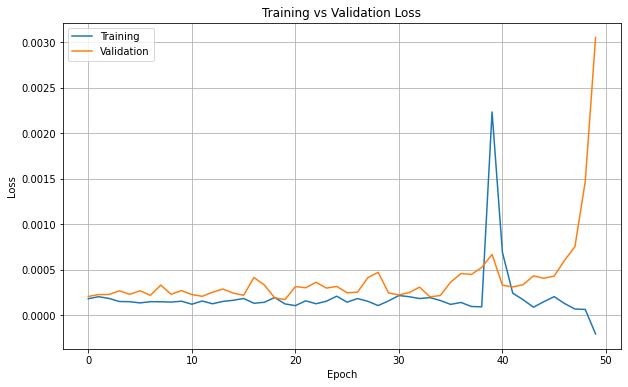

In [13]:
hypermodel.model = model
hypermodel.fit(x_train, y_train, w_train, x_val, y_val, w_val, 50)
hypermodel.plot_loss()